examine 5 yr window not starting from today.

for example, 2019-2024

notes 11/5:


1.   Section off the dataset stratified
2.   combine everything together for random forest





In [10]:
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.1 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.5
    Uninstalling osqp-1.0.5:
      Successfully uninstalled osqp-1.0.5


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



df = pd.read_csv("cross_reference_table.csv", on_bad_lines='skip')

print(df.dtypes)
print(df.shape)
print(df.head())

/tmp/ipython-input-847314697.py:8: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cross_reference_table.csv", on_bad_lines='skip')


id_eu                             object
enisaUuid_eu                      object
description_eu                    object
datePublished_eu                  object
dateUpdated_eu                    object
baseScore_eu                      object
baseScoreVersion_eu               object
baseScoreVector_eu                object
references_eu                     object
aliases_eu                        object
epss_eu                           object
exploitedSince_eu                 object
cve_id                            object
cveID_kev                         object
vendorProject_kev                 object
product_kev                       object
vulnerabilityName_kev             object
dateAdded_kev                     object
shortDescription_kev              object
requiredAction_kev                object
dueDate_kev                       object
knownRansomwareCampaignUse_kev    object
notes_kev                         object
cwes_kev                          object
year_jvn        

In [5]:
date_cols = [
    'datePublished_eu', 'dateUpdated_eu', 'dateAdded_kev',
    'published_date_jvn', 'lastmodified_nvd', 'published_nvd'
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

# Check non-null counts
print(df[date_cols].notnull().sum())


/tmp/ipython-input-1071564458.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
/tmp/ipython-input-1071564458.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
/tmp/ipython-input-1071564458.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)


datePublished_eu      130190
dateUpdated_eu        130153
dateAdded_kev           1852
published_date_jvn      1514
lastmodified_nvd      250868
published_nvd         250881
dtype: int64


In [6]:
df_eu = df.dropna(subset=['dateAdded_kev', 'datePublished_eu']).copy()

# Duration in days
df_eu['duration'] = (df_eu['dateAdded_kev'] - df_eu['datePublished_eu']).dt.total_seconds() / (3600*24)

# Only keep positive durations
df_eu = df_eu[df_eu['duration'] > 0]
df_eu["event_occurred"] = (~df_eu["dateAdded_kev"].isna()).astype(int)

C-index: 0.739


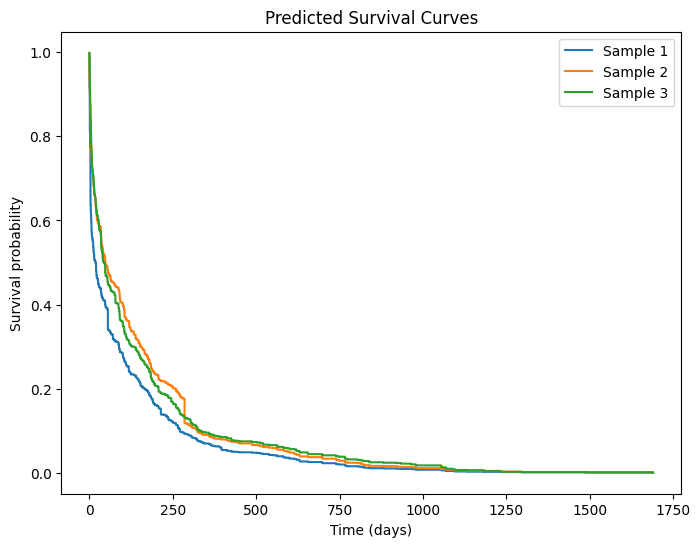

In [11]:
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest

# Create survival data structure
y = Surv.from_arrays(
    event=df_eu["event_occurred"].astype(bool),
    time=df_eu["duration"]
)

# Choose predictors (exclude the date columns)
cols_to_drop = ["dateAdded_kev", "datePublished_eu", "duration", "event_occurred", "ID", "CVE_ID"]
X = df_eu.drop(columns=[c for c in cols_to_drop if c in df_eu.columns])
# Drop datetime columns explicitly
X = X.select_dtypes(exclude=['datetime64[ns, UTC]'])
X = pd.get_dummies(X, drop_first=True)


# Fit Random Survival Forest
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rsf.fit(X, y)

from sksurv.metrics import concordance_index_censored

# Predict risk scores (higher = higher risk)
risk_scores = rsf.predict(X)

# Compute C-index correctly
cindex = concordance_index_censored(
    y["event"],  # boolean array: event occurred?
    y["time"],   # numeric array: observed/censored time
    risk_scores  # predicted risk estimates
)[0]

print(f"C-index: {cindex:.3f}")


from sksurv.nonparametric import kaplan_meier_estimator

# Pick a few examples
example_idx = X.sample(3, random_state=42).index

surv_funcs = rsf.predict_survival_function(X.loc[example_idx])

plt.figure(figsize=(8,6))
for i, fn in enumerate(surv_funcs):
    plt.step(fn.x, fn.y, where="post", label=f"Sample {i+1}")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.title("Predicted Survival Curves")
plt.legend()
plt.show()




BEFORE DOWNSAMPLING:
Total samples: 899
Total events: 899
Event rate: 1.000
Censored rate: 0.000
Stratified downsampling by time periods:

Stratum Q2:
  Total samples: 227
  Events: 227
  Censored: 0
  Event rate: 1.000
  Skipping stratum Q2 - insufficient events or censored cases (227 events, 0 censored)

Stratum Q3:
  Total samples: 222
  Events: 222
  Censored: 0
  Event rate: 1.000
  Skipping stratum Q3 - insufficient events or censored cases (222 events, 0 censored)

Stratum Q1:
  Total samples: 225
  Events: 225
  Censored: 0
  Event rate: 1.000
  Skipping stratum Q1 - insufficient events or censored cases (225 events, 0 censored)

Stratum Q4:
  Total samples: 225
  Events: 225
  Censored: 0
  Event rate: 1.000
  Skipping stratum Q4 - insufficient events or censored cases (225 events, 0 censored)
No data could be downsampled. Returning original data.

TRAINING RANDOM SURVIVAL FOREST ON STRATIFIED DOWNSAMPLED DATA

STRATIFIED DOWNSAMPLING RESULTS:
C-index on original data: 0.739
C

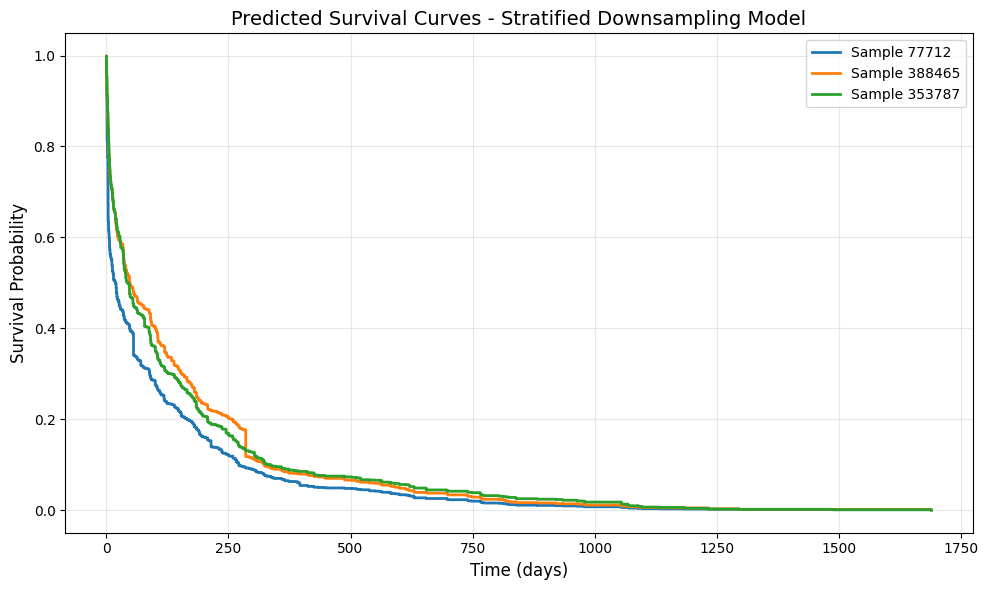

In [14]:
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def stratified_downsample_survival(df, event_col, time_col, target_ratio=0.5, min_samples_per_stratum=50):
    """
    Perform stratified downsampling for survival data by creating time-based strata
    while preserving the event-censoring distribution within each time stratum.

    Parameters:
    - df: DataFrame containing features, event_col, and time_col
    - event_col: Name of the event indicator column
    - time_col: Name of the time-to-event column
    - target_ratio: Target event rate in the downsampled data (default: 0.5)
    - min_samples_per_stratum: Minimum samples to keep from each stratum
    """
    df = df.copy()

    # Create time strata using quartiles
    df['time_stratum'] = pd.qcut(df[time_col], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop') # Added duplicates='drop'

    downsampled_dfs = []

    print("Stratified downsampling by time periods:")
    print("=" * 50)

    for stratum in df['time_stratum'].unique():
        if pd.isna(stratum): # Handle potential NaN stratum if qcut fails
            continue
        stratum_data = df[df['time_stratum'] == stratum]

        # Separate events and censored within stratum
        events_in_stratum = stratum_data[stratum_data[event_col] == True]
        censored_in_stratum = stratum_data[stratum_data[event_col] == False]

        print(f"\nStratum {stratum}:")
        print(f"  Total samples: {len(stratum_data)}")
        print(f"  Events: {len(events_in_stratum)}")
        print(f"  Censored: {len(censored_in_stratum)}")
        # Avoid division by zero if stratum_data is empty
        if len(stratum_data) > 0:
            print(f"  Event rate: {len(events_in_stratum)/len(stratum_data):.3f}")
        else:
            print("  Event rate: N/A (empty stratum)")


        # Calculate target numbers to achieve desired ratio
        if len(events_in_stratum) > 0 and len(censored_in_stratum) > 0:
            # Ensure we have minimum samples from each stratum
            n_events_target = max(min_samples_per_stratum // 2,
                                 min(len(events_in_stratum),
                                     int(min_samples_per_stratum * target_ratio)))
            n_censored_target = max(min_samples_per_stratum // 2,
                                   min(len(censored_in_stratum),
                                       int(min_samples_per_stratum * (1 - target_ratio))))

            # Adjust to maintain ratio if possible
            # Calculate based on available samples if targets exceed them
            total_target = n_events_target + n_censored_target
            if total_target > len(stratum_data):
                 reduction_factor = len(stratum_data) / total_target
                 n_events_target = int(n_events_target * reduction_factor)
                 n_censored_target = int(n_censored_target * reduction_factor)


            # Ensure at least one sample if possible
            n_events_target = max(1, n_events_target) if len(events_in_stratum) > 0 else 0
            n_censored_target = max(1, n_censored_target) if len(censored_in_stratum) > 0 else 0

            # Re-check if we can sample the target number
            n_events_target = min(n_events_target, len(events_in_stratum))
            n_censored_target = min(n_censored_target, len(censored_in_stratum))


            events_sampled = events_in_stratum.sample(n=n_events_target, random_state=42, replace=False)
            censored_sampled = censored_in_stratum.sample(n=n_censored_target, random_state=42, replace=False)


            downsampled_dfs.extend([events_sampled, censored_sampled])

            print(f"  Sampled - Events: {len(events_sampled)}, Censored: {len(censored_sampled)}")
            # Avoid division by zero
            if (len(events_sampled) + len(censored_sampled)) > 0:
                 print(f"  Resulting event rate: {len(events_sampled)/(len(events_sampled) + len(censored_sampled)):.3f}")
            else:
                 print("  Resulting event rate: N/A (no samples)")

        else:
            print(f"  Skipping stratum {stratum} - insufficient events or censored cases ({len(events_in_stratum)} events, {len(censored_in_stratum)} censored)")


    if downsampled_dfs:
        result = pd.concat(downsampled_dfs, ignore_index=True)
        result = result.drop('time_stratum', axis=1)
        result = result.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

        print(f"\nOverall downsampled dataset:")
        print(f"Total samples: {len(result)}")
        print(f"Total events: {result[event_col].sum()}")
        if len(result) > 0:
             print(f"Final event rate: {result[event_col].sum()/len(result):.3f}")
        else:
             print("Final event rate: N/A (empty dataset)")

        return result
    else:
        print("No data could be downsampled. Returning original data.")
        return df.drop('time_stratum', axis=1)


# Create survival data structure
y = Surv.from_arrays(
    event=df_eu["event_occurred"].astype(bool),
    time=df_eu["duration"]
)

# Choose predictors (exclude the date columns)
cols_to_drop = ["dateAdded_kev", "datePublished_eu", "duration", "event_occurred", "ID", "CVE_ID"]
X = df_eu.drop(columns=[c for c in cols_to_drop if c in df_eu.columns])
# Drop datetime columns explicitly
X = X.select_dtypes(exclude=['datetime64[ns, UTC]'])
X = pd.get_dummies(X, drop_first=True)

# Combine X and y for stratified downsampling
data_combined = X.copy()
data_combined['event'] = y['event']
data_combined['time'] = y['time']

print("BEFORE DOWNSAMPLING:")
print("=" * 30)
print(f"Total samples: {len(data_combined)}")
print(f"Total events: {data_combined['event'].sum()}")
if len(data_combined) > 0:
    print(f"Event rate: {data_combined['event'].sum()/len(data_combined):.3f}")
    print(f"Censored rate: {1 - data_combined['event'].sum()/len(data_combined):.3f}")
else:
    print("Event rate: N/A (empty dataset)")
    print("Censored rate: N/A (empty dataset)")


# Apply stratified downsampling
df_downsampled = stratified_downsample_survival(
    data_combined,
    event_col='event',
    time_col='time',
    target_ratio=0.5,  # Aim for balanced dataset
    min_samples_per_stratum=30  # Minimum samples from each time quartile
)

# Split back into X and y
# Check if downsampling returned an empty DataFrame
if not df_downsampled.empty:
    X_downsampled = df_downsampled.drop(['event', 'time'], axis=1)
    y_downsampled = Surv.from_arrays(
        event=df_downsampled['event'].astype(bool),
        time=df_downsampled['time']
    )

    # Fit Random Survival Forest on stratified downsampled data
    print("\n" + "=" * 50)
    print("TRAINING RANDOM SURVIVAL FOREST ON STRATIFIED DOWNSAMPLED DATA")
    print("=" * 50)

    rsf_stratified = RandomSurvivalForest(
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rsf_stratified.fit(X_downsampled, y_downsampled)

    # Evaluate on original data (important for fair comparison)
    risk_scores_stratified = rsf_stratified.predict(X)
    cindex_stratified = concordance_index_censored(
        y["event"],
        y["time"],
        risk_scores_stratified
    )[0]

    print(f"\nSTRATIFIED DOWNSAMPLING RESULTS:")
    print(f"C-index on original data: {cindex_stratified:.3f}")

    # Compare with model trained on original data (if you want)
    rsf_original = RandomSurvivalForest(
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rsf_original.fit(X, y)

    risk_scores_original = rsf_original.predict(X)
    cindex_original = concordance_index_censored(
        y["event"],
        y["time"],
        risk_scores_original
    )[0]

    print(f"C-index without downsampling: {cindex_original:.3f}")
    print(f"Difference: {cindex_stratified - cindex_original:+.3f}")

    # Visualize survival curves from stratified downsampled model
    print("\nGENERATING SURVIVAL CURVES...")
    example_idx = X.sample(3, random_state=42).index
    surv_funcs = rsf_stratified.predict_survival_function(X.loc[example_idx])

    plt.figure(figsize=(10, 6))
    for i, fn in enumerate(surv_funcs):
        # Evaluate the step function at its own defined time points for plotting
        plt.step(fn.x, fn(fn.x), where="post", label=f"Sample {example_idx[i]}", linewidth=2)

    plt.xlabel("Time (days)", fontsize=12)
    plt.ylabel("Survival Probability", fontsize=12)
    plt.title("Predicted Survival Curves - Stratified Downsampling Model", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nDownsampling resulted in an empty dataset. Cannot proceed with training and evaluation.")